In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import spearmanr, pearsonr
import os, re, sys
from tqdm.notebook import tqdm
sys.path.append("../src")

import torch
import pyro
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch

In [36]:
import metagnn as mg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading fasta: 0it [00:00, ?it/s]

Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

2024-12-11 22:36:54,715 | INFO : 4853907 paramter model


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-12-11 22:36:56,714 | INFO : Checkpoint model saved at epoch 0
2024-12-11 22:37:06,495 | INFO : Checkpoint model saved at epoch 5
2024-12-11 22:37:16,589 | INFO : Checkpoint model saved at epoch 10
2024-12-11 22:37:26,408 | INFO : Checkpoint model saved at epoch 15
2024-12-11 22:37:36,771 | INFO : Checkpoint model saved at epoch 20
2024-12-11 22:37:46,596 | INFO : Checkpoint model saved at epoch 25
2024-12-11 22:37:56,429 | INFO : Checkpoint model saved at epoch 30
2024-12-11 22:38:06,401 | INFO : Checkpoint model saved at epoch 35
2024-12-11 22:38:16,447 | INFO : Checkpoint model saved at epoch 40
2024-12-11 22:38:26,464 | INFO : Checkpoint model saved at epoch 45


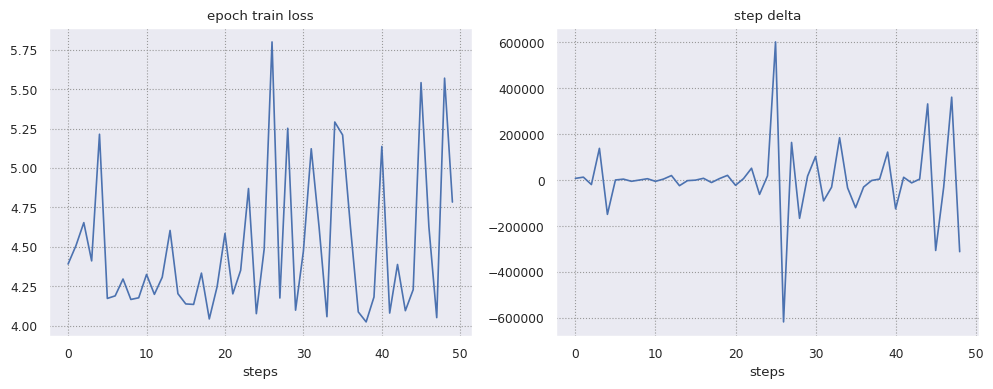

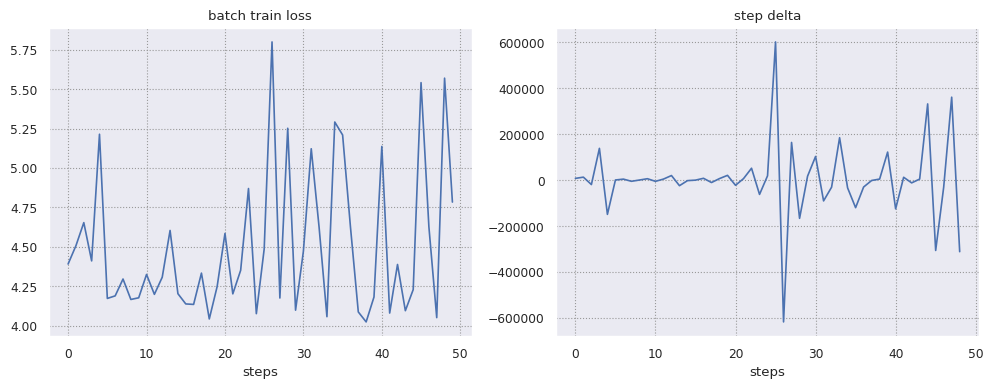

In [571]:
config = mg.tl.MetaGNNConfig(
    batch_size = 24,
    hidden_dim = 128,
    latent_dim = 8,
    num_layers = 2,
    num_components = 3,
    margin=1.,
    learning_rate = .05,
    num_epochs = 50,
    num_workers = 1,
    save_interval = 5,
    contrastive_only=False,
)
mg.tl.train_metagnn("../data/combined.fasta", config)

$$\phi_{i,k} = \frac{\rho_k \cdot f_\theta(\eta_{i,k})}{(1 - \rho_k) + f_\theta(\eta_{i,k})}, \quad \forall i \in \{1, \dots, N\}, \; k \in \{1, \dots, E\}.$$

In [564]:
sample_batch = next(iter(dataloader))

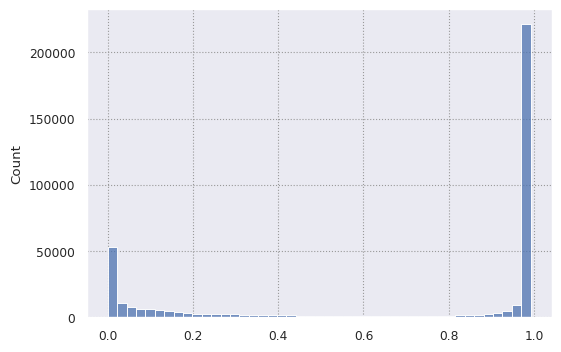

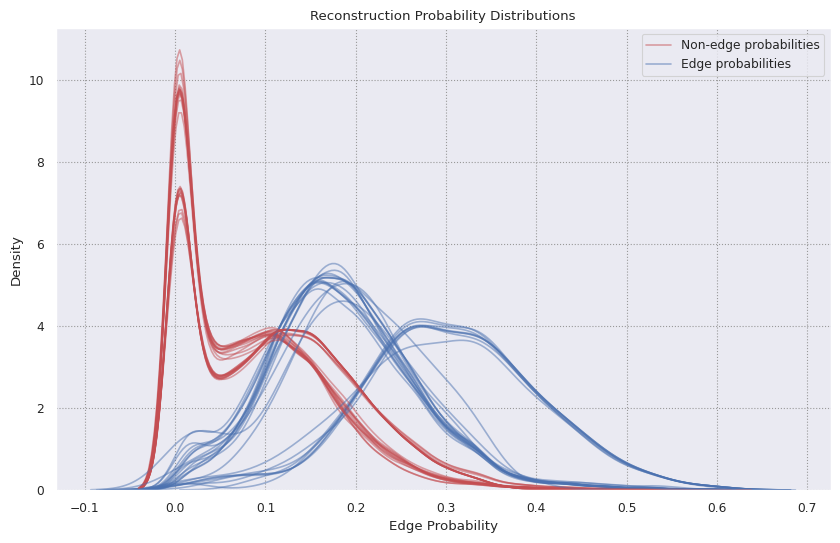

In [568]:
vae = mg.tl.load_model()
mg.pl.reconstruction(vae, sample_batch, (100,))

In [566]:
pyro.param("B_scale")

tensor(1.0180, requires_grad=True)

In [ ]:
config.num_epochs=100
config.save_interval = 1
mg.tl.train_metagnn("../data/combined.fasta", config, run_id=vae.run_id)

In [ ]:
vae = mg.tl.load_model()

In [ ]:
mg.pl.reconstruction(vae, dataset)

In [191]:
dataset = mg.tl.MetagenomeDataset("../data/combined.fasta", config)
dataloader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    collate_fn=dataset.metagenome_collate_fn,
    shuffle=True,
    drop_last=True,
)

Loading fasta: 0it [00:00, ?it/s]

Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

$$ \mathcal{L}(\phi, \theta) = \mathbb{E}{q{\phi}(z, \eta)} \left[ \log p_\theta(X, z, \eta) - \log q_{\phi}(z, \eta) \right] $$

$$\mathcal{L}(\phi, \theta) = \mathbb{E}{q\phi(z, \eta)}
\left[ \sum_{i=1}^N \log \text{Bernoulli}(X_i | f_\theta(\eta[z_i])) \\
\sum_{k=1}^K \log \mathcal{N}(\eta_k | \mu_k, \sigma_k) \\
\sum_{i=1}^N \log \text{Categorical}(z_i | \alpha) \\
\log \text{Dirichlet}(\alpha | 1_k) \right] \\
\text{KL}[q_\phi(z) | p(z)] \\
\text{KL}[q_\phi(\eta | z) | p(\eta | \mu, \sigma)]
$$

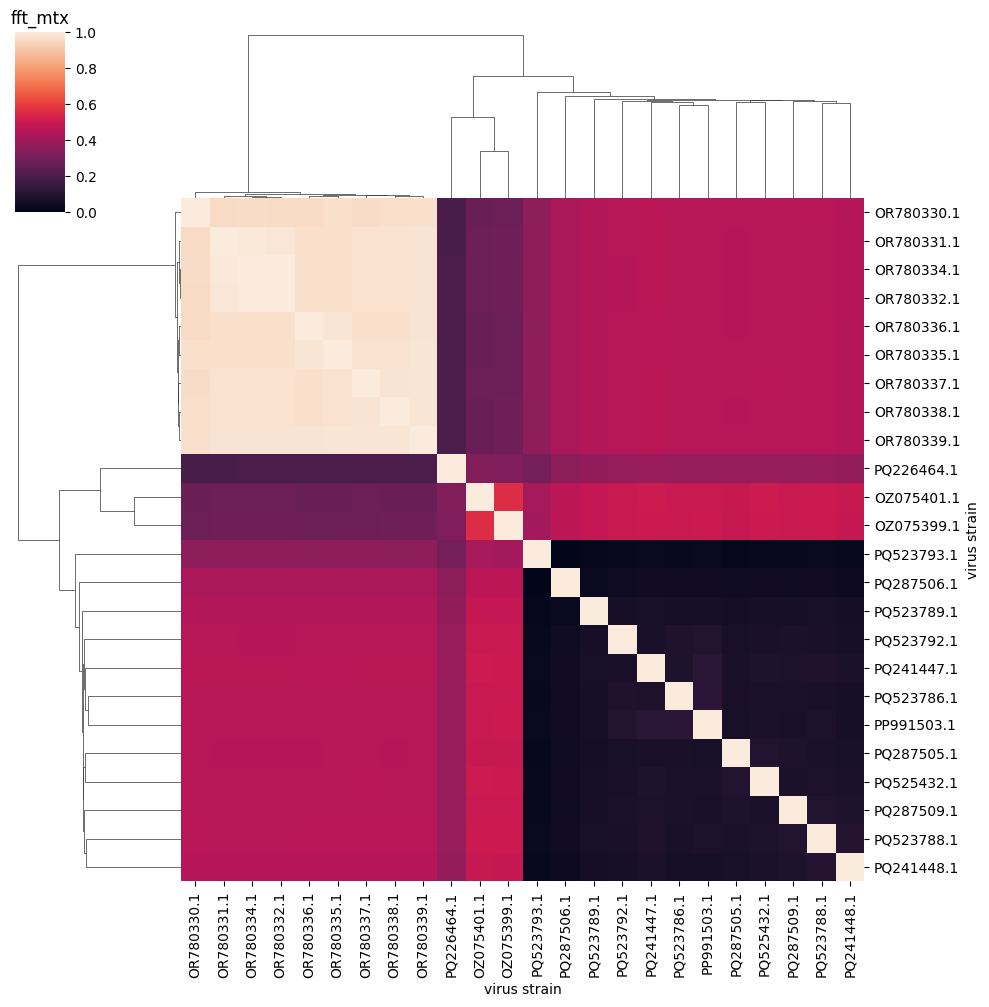

In [17]:
sim_title = "fft_mtx"
sample_batch_df = pd.DataFrame(sample_batch[sim_title], columns=sample_batch["headers"], index=sample_batch["headers"])
sbhm = sns.clustermap(sample_batch_df)
sbhm.ax_heatmap.set_xlabel("virus strain")
sbhm.ax_heatmap.set_ylabel("virus strain")
plt.title(sim_title)
plt.show()

$$
L_{\text{reconstruction}} = \frac{1}{N} \sum_{i=1}^N \left[
\frac{1}{N_i^+} \sum_{e \in E_i^+} \text{BCE}(p(e), 1) +
\frac{1}{N_i^-} \sum_{e \in E_i^-} \text{BCE}(p(e), 0)
\right]
$$

$N$ : Number of observations (batch size).

$E_i^+$ : Set of positive edges in the i-th example (edges that exist).

$E_i^-$ : Set of sampled negative edges in the i-th example (non-existent edges).

$N_i^+$ = $|E_i^+|$ : Number of positive edges in the i-th example.

$N_i^-$ = $|E_i^-|$ : Number of sampled negative edges in the i-th example.

$p(e)$ : Predicted probability for edge $e$.

$\text{BCE}(p(e), t) = -\left[t \log(p(e)) + (1 - t) \log(1 - p(e))\right]$ : Binary cross-entropy for a target $t$ (1 for positive edges, 0 for negative edges).



$
L_{\text{contrastive}}(z_\mu, S, W, m) = 
\frac{\sum_i^N \left( S \cdot D + (1 - S) \cdot \max(m - \sqrt{D}, 0)^2 \right) \cdot W}{\sum W + \epsilon}
$

$
\begin{aligned}
D & = \| z_{\mu, i} - z_{\mu, j} \|_2^2, \\
S & \in [0, 1]^{N \times N}, \\
W & \in [0, 1]^{N \times N}, \\
\end{aligned}
$

for similarity $S$, observation weights $W$, margin $m$, and latent representation $z$.

$\begin{align}
L_{\text{ELBO}} = & \mathbb{E}_{q_{\phi}(z,\eta,\mu,\sigma,\alpha|X)} \left[ \log p_{\theta}(X|z,\eta) \right] \\
& - \text{KL}\left(q_{\phi}(z|X) \parallel p_{\theta}(z)\right) \\
& - \text{KL}\left(q_{\phi}(\eta|z,X) \parallel p_{\theta}(\eta|z)\right) \\
& - \text{KL}\left(q_{\phi}(\mu) \parallel p_{\theta}(\mu)\right) \\
& - \text{KL}\left(q_{\phi}(\sigma) \parallel p_{\theta}(\sigma)\right) \\
& - \text{KL}\left(q_{\phi}(\alpha) \parallel p_{\theta}(\alpha)\right) \\
& + \mathbb{E}_{q_{\phi}(z)} \left[ \log p_{\theta}(\beta | z) \right]
\end{align}$

where

$X$ is the input graph

$z$ is the mixture component assignment

$\eta$ is the latent representation

$\mu$ and $\sigma$ are the means and scales of the mixture components

$\alpha$ is the Dirichlet prior parameter for mixture weights

$\beta$ is the similarity penalty term from the FFT matrix

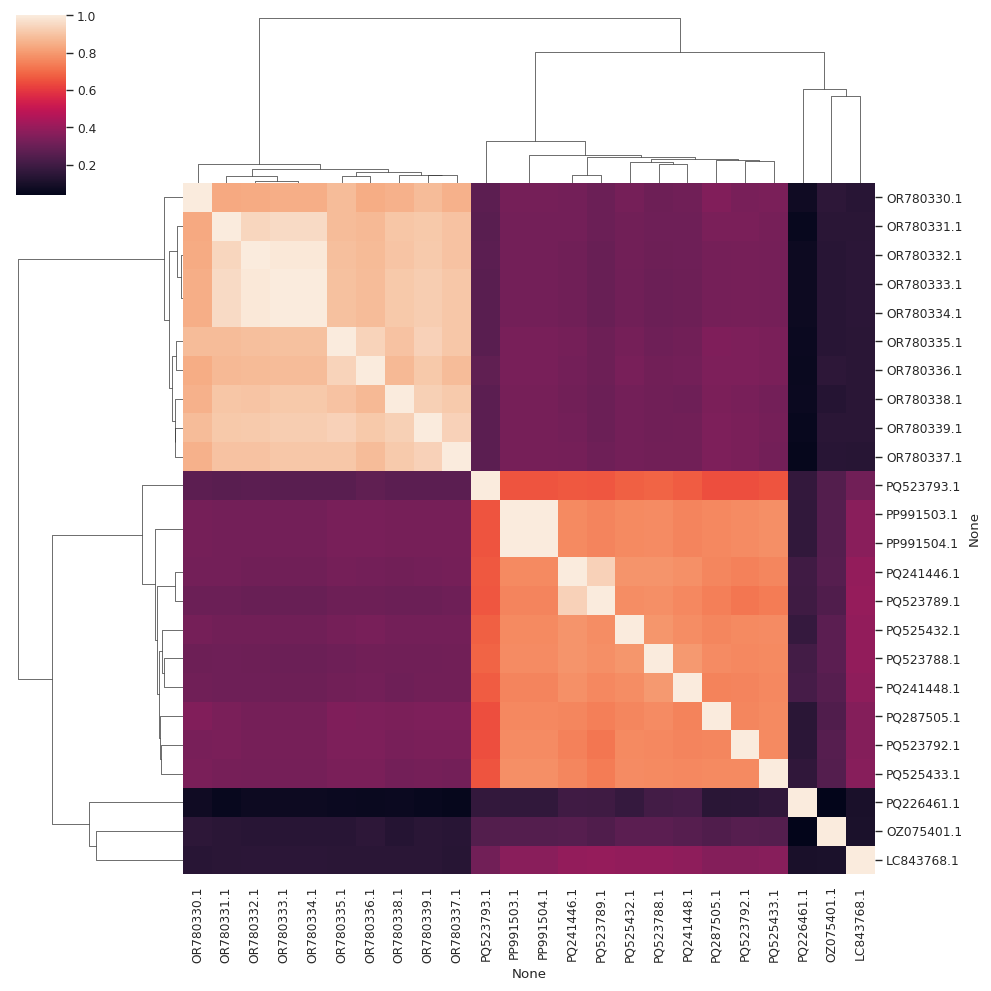

In [136]:
ani_df = pd.DataFrame(sample_batch["graph_sim"], columns=sample_batch["headers"], index=sample_batch["headers"])
sns.clustermap(ani_df)

In [139]:
# mg.pl.reconstruction(dataset, vae)

In [13]:
num_nodes = 4**(config.k-1)
num_edges = sample_batch["graphs"].get_example(6).edge_index.size(1)
max_possible_edges = num_nodes * (num_nodes - 1) / 2 
1 - (num_edges / max_possible_edges)

0.9993265415140415

In [127]:
# sample_batch = next(iter(dataloader))

# Flatten matrices (exclude diagonal elements)
def flatten_matrix(mat):
    # Extract upper triangle without diagonal
    return mat[np.triu_indices_from(mat, k=1)]

# Flatten matrices
ani_values = flatten_matrix(sample_batch["graph_sim"])
fft_values = flatten_matrix(sample_batch["fft_mtx"])
wgt_values = flatten_matrix(sample_batch["len_ratio"])

# Perform correlation tests
ani_corr, ani_p = spearmanr(wgt_values, ani_values)  # Spearman correlation
fft_corr, fft_p = spearmanr(wgt_values, fft_values)  # Spearman correlation

# Print results
print(f"Spearman correlation between Length Ratio and ANI: r={ani_corr:.3f}, p={ani_p:.3e}")
print(f"Spearman correlation between Length Ratio and FFT: r={fft_corr:.3f}, p={fft_p:.3e}")

# Optional: Pearson correlation for linear relationships
ani_corr_pearson, ani_p_pearson = pearsonr(wgt_values, ani_values)
fft_corr_pearson, fft_p_pearson = pearsonr(wgt_values, fft_values)
print(f"Pearson correlation between Length Ratio and ANI: r={ani_corr_pearson:.3f}, p={ani_p_pearson:.3e}")
print(f"Pearson correlation between Length Ratio and FFT: r={fft_corr_pearson:.3f}, p={fft_p_pearson:.3e}")

Spearman correlation between Length Ratio and ANI: r=0.304, p=2.551e-07
Spearman correlation between Length Ratio and FFT: r=-0.316, p=7.950e-08
Pearson correlation between Length Ratio and ANI: r=-0.210, p=4.446e-04
Pearson correlation between Length Ratio and FFT: r=0.066, p=2.748e-01


<Axes: ylabel='Count'>

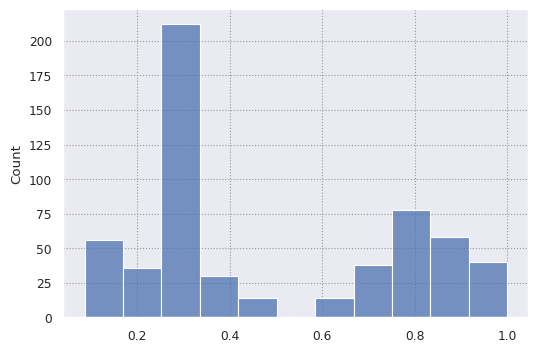

In [87]:
sns.histplot(sample_batch["graph_sim"].flatten())

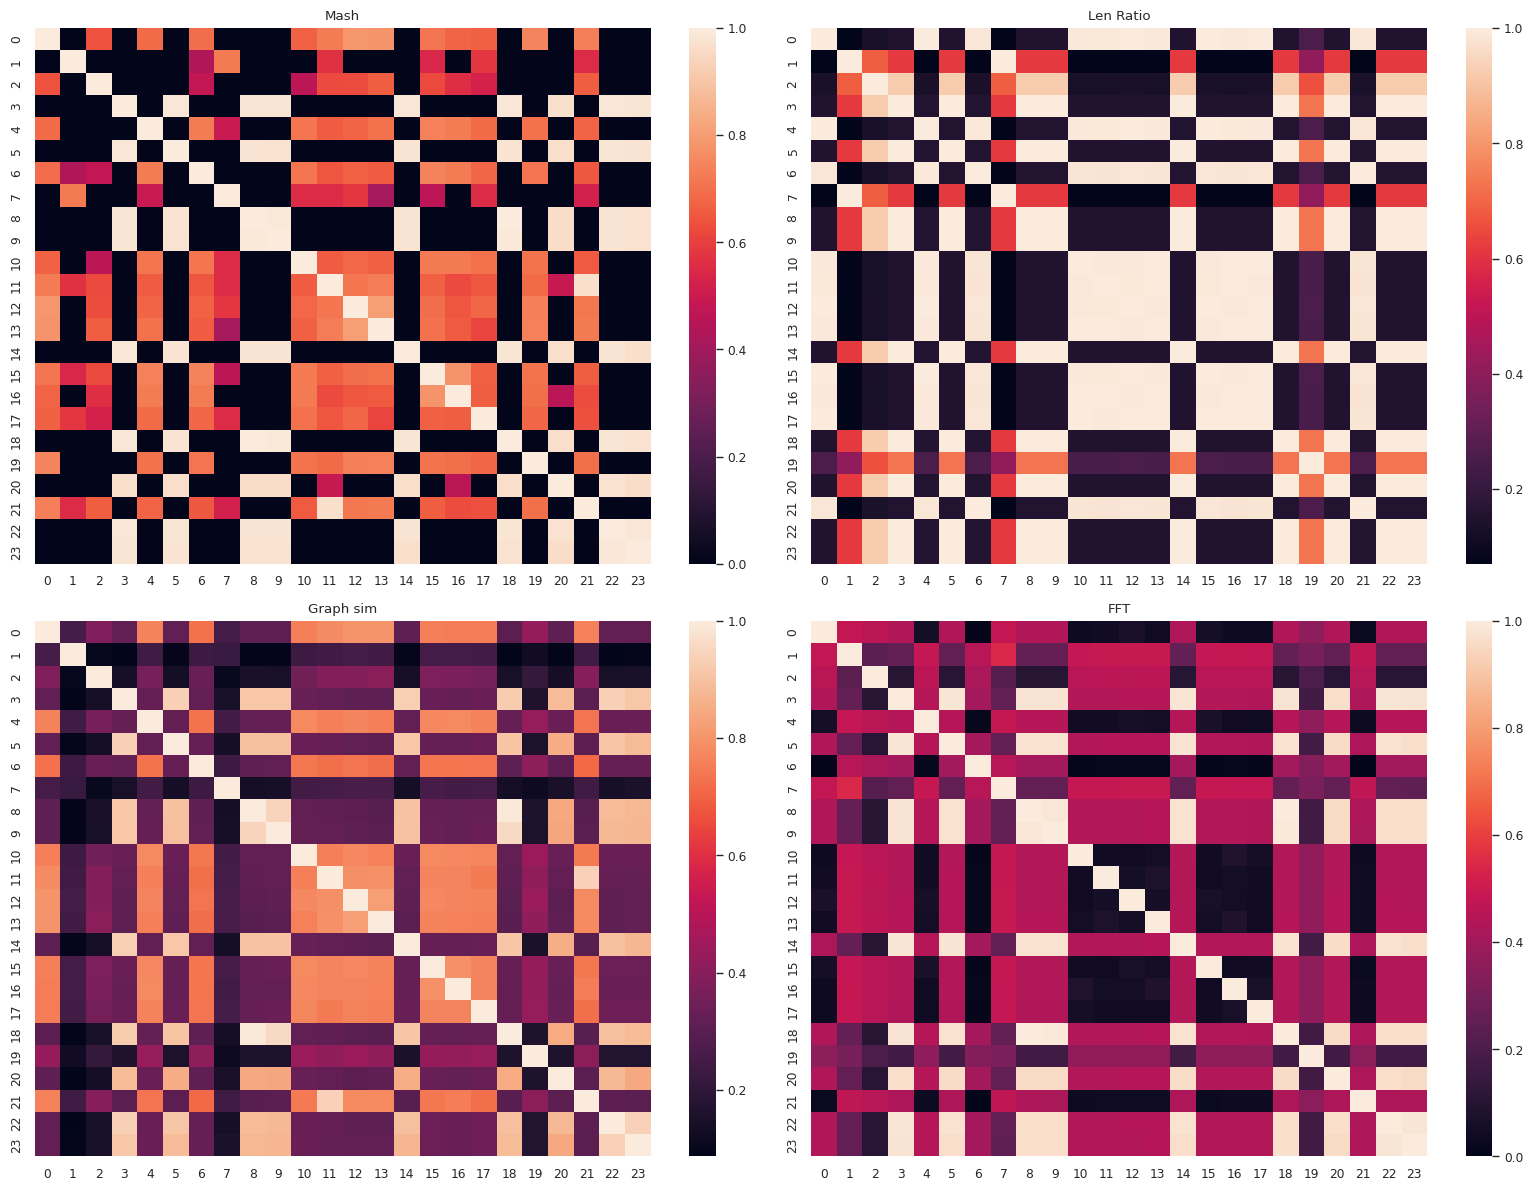

In [138]:
sample_batch = next(iter(dataloader))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.heatmap(sample_batch["mash_mtx"], ax=axes[0][0], cbar=True)
sns.heatmap(sample_batch["len_ratio"], ax=axes[0][1], cbar=True)
sns.heatmap(sample_batch["graph_sim"], ax=axes[1][0], cbar=True)
sns.heatmap(sample_batch["fft_mtx"], ax=axes[1][1], cbar=True)

axes[0][0].set_title("Mash")
axes[0][1].set_title("Len Ratio")
axes[1][0].set_title("Graph sim")
axes[1][1].set_title("FFT")
plt.tight_layout()
plt.show()

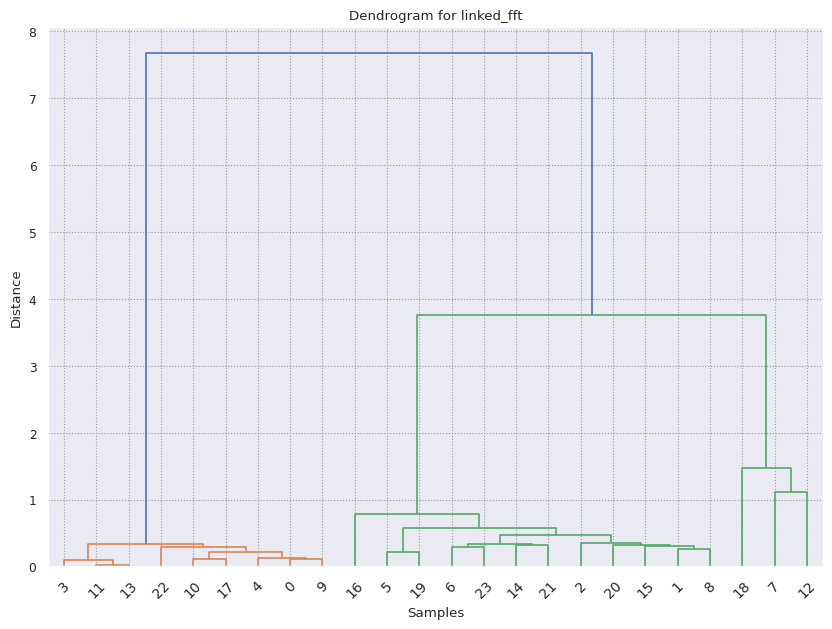

In [98]:
import scipy.cluster.hierarchy as sch
fft_mtx = sample_batch["graph_sim"]
linked_fft = sch.linkage(fft_mtx, method='ward')

plt.figure(figsize=(10, 7))
sch.dendrogram(linked_fft)
plt.title("Dendrogram for linked_fft")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [100]:
labels_fft = fcluster(linked_fft, k, criterion='maxclust')

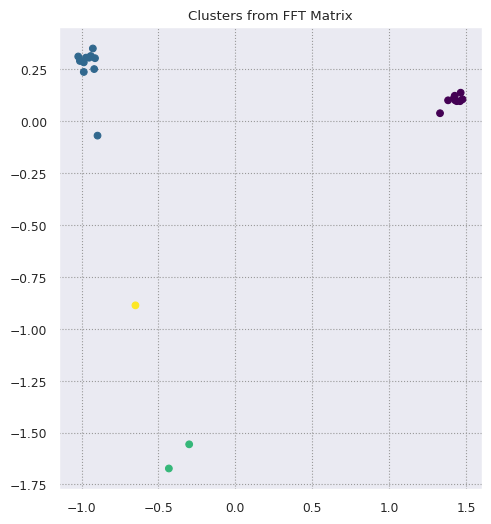

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_fft = pca.fit_transform(sample_batch["graph_sim"])

# Plot clusters
plt.figure(figsize=(12, 6))

# fft clusters
plt.subplot(1, 2, 2)
plt.scatter(reduced_fft[:, 0], reduced_fft[:, 1], c=labels_fft, cmap='viridis')
plt.title("Clusters from FFT Matrix")

plt.show()

In [24]:
import numpy as np

# Pairwise co-membership matrices
membership_wgt = np.equal.outer(labels_wgt, labels_wgt).astype(int)
membership_fft = np.equal.outer(labels_fft, labels_fft).astype(int)

# Compute similarity between co-membership matrices
overlap = np.sum(membership_wgt * membership_fft) / np.sum(membership_wgt + membership_fft)

print(f"Co-membership overlap: {overlap}")

Co-membership overlap: 0.40446841294298924


In [58]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Define the number of clusters for comparison (k)
k = 4  # Adjust as needed

# Extract cluster labels
labels_wgt = fcluster(linked_wgt, k, criterion='maxclust')
labels_fft = fcluster(linked_fft, k, criterion='maxclust')

# Compare clusters using metrics
ari = adjusted_rand_score(labels_wgt, labels_fft)
nmi = normalized_mutual_info_score(labels_wgt, labels_fft)

print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Adjusted Rand Index (ARI): 0.582889808791642
Normalized Mutual Information (NMI): 0.6949603450296534


In [59]:
# pyro.render_model(vae.model,model_args=(sample_batch,))

In [60]:
# pyro.render_model(vae.guide,model_args=(sample_batch,))

In [62]:
for batch in dataloader:
    fft_mtx = batch['fft_mtx']
    graphs = batch['graphs']
    headers = batch["headers"][0]
    headers = [tuple(s.split()[:2]) for s in headers]
    sim_df = pd.DataFrame(fft_mtx, columns=headers, index=headers)
    sns.clustermap(sim_df, annot=True, fmt=".2f",)
    plt.show()

In [63]:
# pyro.get_param_store().keys()

[[-0.46919155  0.07798213]
 [ 0.38258466  0.14643794]
 [ 0.08660692 -0.22442013]]


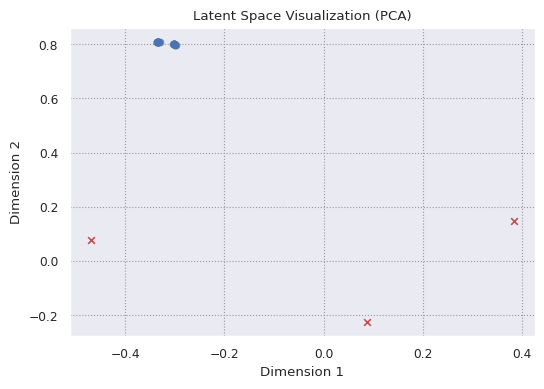

In [482]:
def visualize_latent_space(model, batch, method="tsne"):
    """
    Visualize the latent space (eta) using PCA or t-SNE.
    """
    with torch.no_grad():
        eta_loc = pyro.param("eta_locs_q")
    if method.lower() == "pca":
        pca = PCA(n_components=2).fit(eta_loc.detach().numpy())
        reduced = pca.transform(eta_loc.detach().numpy())
        reduced_batch = pca.transform(model._guide(batch["graphs"], batch["graph_sim"])[0].detach().numpy())
    elif method.lower() == "tsne":
        reduced = TSNE(n_components=2, perplexity=1).fit_transform(eta_loc.detach().numpy())
        reduced_batch = pca.transform(model._guide(batch["graphs"], batch["graph_sim"])[0].detach().numpy())
    else:
        raise ValueError("Method should be 'pca' or 'tsne'")
    print(reduced)
    plt.scatter(reduced_batch[:, 0], reduced_batch[:, 1], alpha=.6)
    plt.scatter(reduced[:, 0], reduced[:, 1], c="r", marker="x", alpha=1.)
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
visualize_latent_space(vae, sample_batch, method="pca")

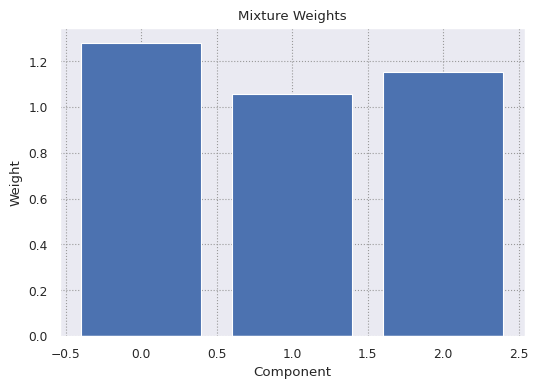

In [483]:
def plot_mixture_weights(model):
    """
    Plot the learned mixture weights.
    """
    weights = pyro.param("weights_q").detach().numpy()
    plt.bar(range(len(weights)), weights)
    plt.xlabel("Component")
    plt.ylabel("Weight")
    plt.title("Mixture Weights")
    plt.show()
plot_mixture_weights(vae)

In [488]:
from sklearn.metrics import precision_recall_fscore_support
from metagnn.tools.model.vae import batch_to_obs
def evaluate_reconstruction(model, batch):
    """
    Evaluate reconstruction quality by comparing true and reconstructed edges.
    """
    with torch.no_grad():
        _, decoded_edges = model.model(batch["graphs"], batch["graph_sim"])
        edge_probas, edge_observations = batch_to_obs(decoded_edges, batch["graphs"])
    precision, recall, f1, _ = precision_recall_fscore_support(
        edge_observations.flatten(), (edge_probas > 0.3).to(int).flatten(), average="binary"
    )
    return {"precision": precision, "recall": recall, "f1": f1}
evaluate_reconstruction(vae, sample_batch)

{'precision': np.float64(0.1677628778807466),
 'recall': np.float64(0.4453315657859058),
 'f1': np.float64(0.24371483336424907)}

In [489]:
def cluster_statistics(model, batch):
    """
    Summarize statistics for each cluster (mean and std of eta).
    """
    with torch.no_grad():
        eta_locs_q = pyro.param("eta_locs_q").detach().numpy()
        eta_scales_q = pyro.param("eta_scales_q").detach().numpy()
    stats = {
        f"Cluster {i}": {"mean": loc.tolist(), "std": scale.tolist()}
        for i, (loc, scale) in enumerate(zip(eta_locs_q, eta_scales_q))
    }
    return stats
cluster_statistics(vae, sample_batch)

{'Cluster 0': {'mean': [0.5623267292976379,
   -0.11520237475633621,
   -0.16461104154586792,
   0.37059280276298523,
   -0.7766103148460388,
   0.4178257882595062,
   0.6477258205413818,
   -1.0639572143554688],
  'std': [0.27902498841285706,
   0.40973594784736633,
   0.29503023624420166,
   0.25380849838256836,
   0.26226338744163513,
   0.34408149123191833,
   0.4336272180080414,
   0.17450597882270813]},
 'Cluster 1': {'mean': [0.6160153150558472,
   0.6058987379074097,
   -0.13191786408424377,
   0.27164384722709656,
   -0.5365915298461914,
   0.19682368636131287,
   0.9477491974830627,
   -1.0601000785827637],
  'std': [0.20922157168388367,
   0.43681126832962036,
   0.2100217342376709,
   0.2271224558353424,
   0.2261333167552948,
   0.26703396439552307,
   0.28532591462135315,
   0.27787965536117554]},
 'Cluster 2': {'mean': [0.517932116985321,
   0.45412367582321167,
   -0.18782666325569153,
   0.4593093693256378,
   -0.8998202085494995,
   0.28243210911750793,
   0.827033698

In [138]:
def feature_importances(model, batch):
    """
    Inspect features contributing most to cluster separations.
    """
    with torch.no_grad():
        eta_locs_q = pyro.param("eta_locs_q").detach()
    return torch.var(eta_locs_q, dim=0).numpy()
feature_importances(vae, sample_batch)

array([0.4586462 , 1.8265418 , 1.3335738 , 0.19017583, 0.21597327,
       3.3797843 , 0.01486664, 1.5992496 , 4.0238643 , 1.337     ,
       1.5592303 , 0.17289267, 1.7827401 , 3.2963612 , 0.2712314 ,
       0.2652723 ], dtype=float32)

In [539]:
from pyro.infer import infer_discrete
import pyro.poutine as poutine
from pyro.infer import config_enumerate

@config_enumerate
def classifier(vae, batch, temperature=0):
    data = batch["graphs"], batch["graph_sim"]
    vae.eval()
    guide_trace = poutine.trace(vae._guide).get_trace(*data)  # record the globals
    trained_model = poutine.replay(vae._model, trace=guide_trace)  # replay the globals

    inferred_model = infer_discrete(
        trained_model, temperature=temperature, first_available_dim=-1
    )
    return inferred_model
    
# check_df = pd.DataFrame(batch["graph_sim"],columns=batch["headers"], index=batch["headers"])
# sns.clustermap(check_df)
sample_data = sample_batch["graphs"], sample_batch["graph_sim"]

trace = poutine.trace(cf).get_trace(*sample_data)
# for h, z in zip(sample_batch["headers"][0],trace.nodes["eta"]["value"].detach().numpy()):
#     print(h,z)

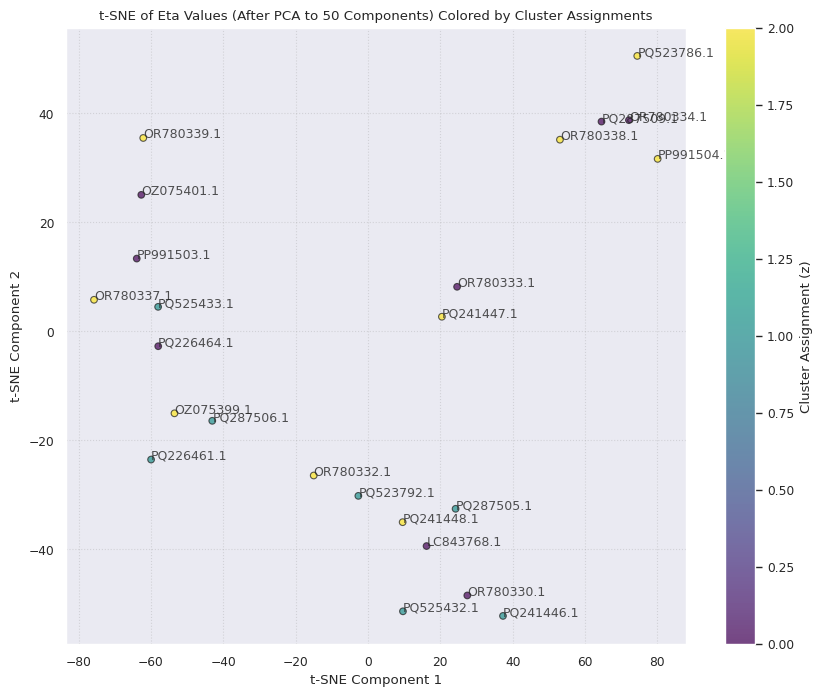

In [551]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform PCA with 50 components
pca_50 = PCA(n_components=8)
eta_50d = pca_50.fit_transform(eta_values)

# Perform t-SNE on the 50 PCA components
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
eta_tsne = tsne.fit_transform(eta_50d)

# Extract cluster assignments ("z") from the trace
z_assignments = trace.nodes["z"]["value"].detach().numpy()

# Plot the t-SNE results colored by cluster assignments
plt.figure(figsize=(10, 8))
scatter = plt.scatter(eta_tsne[:, 0], eta_tsne[:, 1], c=z_assignments, cmap="viridis", alpha=0.7, edgecolors='k')
plt.colorbar(scatter, label="Cluster Assignment (z)")

# Annotate points with headers
for i, header in enumerate(headers):
    plt.annotate(header, (eta_tsne[i, 0], eta_tsne[i, 1]), fontsize=9, alpha=0.8)

plt.title("t-SNE of Eta Values (After PCA to 50 Components) Colored by Cluster Assignments")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(alpha=0.3)
plt.show()

In [520]:
for k in pyro.get_param_store().keys(): print(k) if "$" not in k else None

weights_q
eta_locs_q
eta_scales_q
z_probs


$${\displaystyle H^{2}(P,Q)=1-{\sqrt {\frac {2\sigma _{1}\sigma _{2}}{\sigma _{1}^{2}+\sigma _{2}^{2}}}}\,e^{-{\frac {1}{4}}{\frac {(\mu _{1}-\mu _{2})^{2}}{\sigma _{1}^{2}+\sigma _{2}^{2}}}}.}$$

In [176]:
m1, m2, s1, s2 = 0, 0, 1, 1
print(hellinger(m1, m2, s1, s2))  # Should return 0 (no distance)

# Case 2: Completely non-overlapping Gaussians
m1, m2, s1, s2 = 0, 10, 1, 1
print(hellinger(m1, m2, s1, s2))  # Should return close to 1 (maximum distance)

# Case 3: Different variances
m1, m2, s1, s2 = 0, 0, 1, 2
print(hellinger(m1, m2, s1, s2)) 

tensor(0.)
tensor(1.0000)
tensor(0.3249)


In [175]:
def hellinger(m1, m2, s1, s2):
    m1, m2, s1, s2 = map(torch.tensor, (m1, m2, s1, s2)) 
    return torch.sqrt(1 - torch.sqrt(
        2*s1*s2 / (s1**2 + s2**2)
    ) * torch.exp(
        -.25 * (m1-m2)**2 / (s1**2 + s2**2)
    ))

In [172]:
hellinger(torch.tensor(0), torch.tensor(0), torch.tensor(1), torch.tensor(1))

tensor(1.)

In [188]:
torch.cosine_similarity

<function torch._VariableFunctionsClass.cosine_similarity>

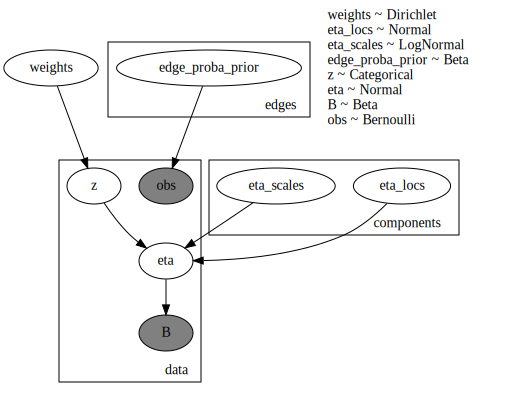

In [569]:
pyro.render_model(vae.model, model_args=(*sample_data,), render_distributions=True, render_params=False)

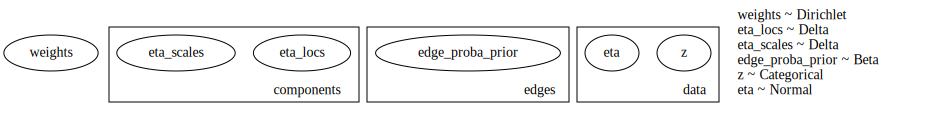

In [558]:
pyro.render_model(vae.guide, model_args=(*sample_data,), render_distributions=True, render_params=False)